In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import set_config, Callback

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else"cpu")
device

device(type='cpu')

# Import Data

In [4]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


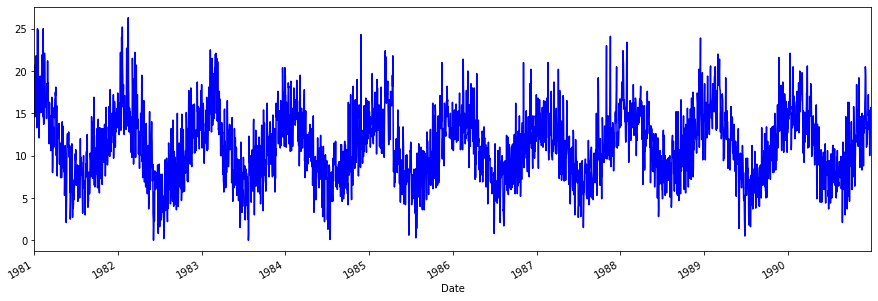

In [5]:
df.Temp.plot(figsize=(15, 5), color="b");

# Dataset splitting

In [6]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset dan Dataloader



In [9]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [10]:
seq_len = 14
bs = 32         

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)


(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur dan config


In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden      

In [13]:
config = set_config({
    "input_size" : train_set.n_feature,
    "seq_len" : train_set.n_seq,
    "output_size" : 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0
})

# Training preparation -> MCOC

In [14]:
model = LSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/lstm")


# Training

In [15]:

from tqdm.auto import tqdm


def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost




Epoch     1
Train_cost  = 135.7243 | Test_cost  = 137.0219 | 




Epoch     2
Train_cost  = 122.6546 | Test_cost  = 119.0411 | 




Epoch     3
Train_cost  = 103.2134 | Test_cost  = 97.6499 | 




Epoch     4
Train_cost  = 83.3164 | Test_cost  = 78.5376 | 




Epoch     5
Train_cost  = 66.3274 | Test_cost  = 63.1808 | 




Epoch     6
Train_cost  = 53.5721 | Test_cost  = 52.5230 | 




Epoch     7
Train_cost  = 44.9610 | Test_cost  = 45.1841 | 




Epoch     8
Train_cost  = 38.9175 | Test_cost  = 39.7305 | 




Epoch     9
Train_cost  = 34.3639 | Test_cost  = 35.4527 | 




Epoch    10
Train_cost  = 30.7892 | Test_cost  = 32.0189 | 




Epoch    11
Train_cost  = 27.9416 | Test_cost  = 29.2433 | 




Epoch    12
Train_cost  = 25.6674 | Test_cost  = 26.9986 | 




Epoch    13
Train_cost  = 23.8554 | Test_cost  = 25.1873 | 




Epoch    14
Train_cost  = 22.4185 | Test_cost  = 23.7308 | 




Epoch    15
Train_cost  = 21.2856 | Test_cost  = 22.5640 | 




Epoch    16
Train_cost  = 20.3976 | Test_cost  = 21.6328 | 




Epoch    17
Train_cost  = 19.7055 | Test_cost  = 20.8916 | 




Epoch    18
Train_cost  = 19.1684 | Test_cost  = 20.3027 | 




Epoch    19
Train_cost  = 18.7528 | Test_cost  = 19.8349 | 




Epoch    20
Train_cost  = 18.4312 | Test_cost  = 19.4626 | 


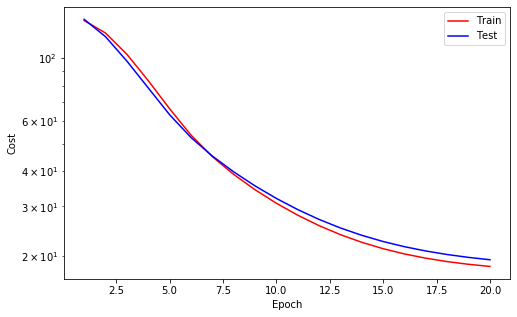



Epoch    21
Train_cost  = 18.1816 | Test_cost  = 19.1651 | 




Epoch    22
Train_cost  = 17.9867 | Test_cost  = 18.9259 | 




Epoch    23
Train_cost  = 17.8327 | Test_cost  = 18.7319 | 




Epoch    24
Train_cost  = 17.7093 | Test_cost  = 18.5731 | 




Epoch    25
Train_cost  = 17.6085 | Test_cost  = 18.4416 | 




Epoch    26
Train_cost  = 17.5247 | Test_cost  = 18.3315 | 




Epoch    27
Train_cost  = 17.4535 | Test_cost  = 18.2383 | 




Epoch    28
Train_cost  = 17.3921 | Test_cost  = 18.1589 | 




Epoch    29
Train_cost  = 17.3384 | Test_cost  = 18.0907 | 




Epoch    30
Train_cost  = 17.2911 | Test_cost  = 18.0320 | 




Epoch    31
Train_cost  = 17.2492 | Test_cost  = 17.9811 | 




Epoch    32
Train_cost  = 17.2117 | Test_cost  = 17.9367 | 




Epoch    33
Train_cost  = 17.1781 | Test_cost  = 17.8976 | 




Epoch    34
Train_cost  = 17.1477 | Test_cost  = 17.8632 | 




Epoch    35
Train_cost  = 17.1204 | Test_cost  = 17.8332 | 




Epoch    36
Train_cost  = 17.0958 | Test_cost  = 17.8067 | 




Epoch    37
Train_cost  = 17.0734 | Test_cost  = 17.7826 | 




Epoch    38
Train_cost  = 17.0514 | Test_cost  = 17.7580 | 




Epoch    39
Train_cost  = 17.0296 | Test_cost  = 17.7383 | 




Epoch    40
Train_cost  = 17.0125 | Test_cost  = 17.7213 | 


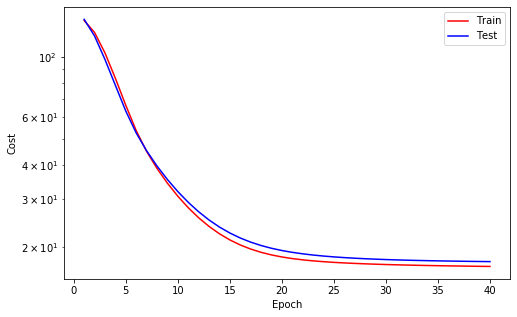



Epoch    41
Train_cost  = 16.9968 | Test_cost  = 17.7049 | 




Epoch    42
Train_cost  = 16.9820 | Test_cost  = 17.6896 | 




Epoch    43
Train_cost  = 16.9681 | Test_cost  = 17.6755 | 




Epoch    44
Train_cost  = 16.9554 | Test_cost  = 17.6628 | 




Epoch    45
Train_cost  = 16.9435 | Test_cost  = 17.6510 | 




Epoch    46
Train_cost  = 16.9324 | Test_cost  = 17.6399 | 




Epoch    47
Train_cost  = 16.9219 | Test_cost  = 17.6295 | 




Epoch    48
Train_cost  = 16.9119 | Test_cost  = 17.6197 | 




Epoch    49
Train_cost  = 16.9025 | Test_cost  = 17.6104 | 




Epoch    50
Train_cost  = 16.8935 | Test_cost  = 17.6016 | 




Epoch    51
Train_cost  = 16.8848 | Test_cost  = 17.5931 | 




Epoch    52
Train_cost  = 16.8764 | Test_cost  = 17.5847 | 




Epoch    53
Train_cost  = 16.8673 | Test_cost  = 17.5737 | 




Epoch    54
Train_cost  = 16.8557 | Test_cost  = 17.5646 | 




Epoch    55
Train_cost  = 16.8474 | Test_cost  = 17.5572 | 




Epoch    56
Train_cost  = 16.8395 | Test_cost  = 17.5493 | 




Epoch    57
Train_cost  = 16.8315 | Test_cost  = 17.5413 | 




Epoch    58
Train_cost  = 16.8236 | Test_cost  = 17.5336 | 




Epoch    59
Train_cost  = 16.8152 | Test_cost  = 17.5247 | 




Epoch    60
Train_cost  = 16.7989 | Test_cost  = 17.4985 | 


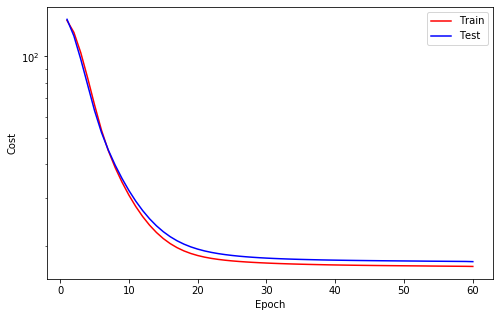



Epoch    61
Train_cost  = 16.7783 | Test_cost  = 17.4888 | 




Epoch    62
Train_cost  = 16.7657 | Test_cost  = 17.4747 | 




Epoch    63
Train_cost  = 16.7494 | Test_cost  = 17.4565 | 




Epoch    64
Train_cost  = 16.7277 | Test_cost  = 17.4298 | 




Epoch    65
Train_cost  = 16.6930 | Test_cost  = 17.3716 | 




Epoch    66
Train_cost  = 16.6022 | Test_cost  = 17.2403 | 




Epoch    67
Train_cost  = 16.4468 | Test_cost  = 17.0538 | 




Epoch    68
Train_cost  = 16.2249 | Test_cost  = 16.7961 | 




Epoch    69
Train_cost  = 15.8906 | Test_cost  = 16.3264 | 




Epoch    70
Train_cost  = 15.4028 | Test_cost  = 15.6700 | 




Epoch    71
Train_cost  = 14.5869 | Test_cost  = 14.4894 | 




Epoch    72
Train_cost  = 13.2628 | Test_cost  = 13.1939 | 




Epoch    73
Train_cost  = 12.1777 | Test_cost  = 12.3961 | 




Epoch    74
Train_cost  = 11.6479 | Test_cost  = 11.6074 | 




Epoch    75
Train_cost  = 10.9415 | Test_cost  = 10.6953 | 




Epoch    76
Train_cost  = 10.3877 | Test_cost  = 10.1239 | 




Epoch    77
Train_cost  = 9.8680 | Test_cost  = 9.6391 | 




Epoch    78
Train_cost  = 9.4625 | Test_cost  = 9.2274 | 




Epoch    79
Train_cost  = 9.1832 | Test_cost  = 8.8843 | 




Epoch    80
Train_cost  = 8.8807 | Test_cost  = 8.5365 | 


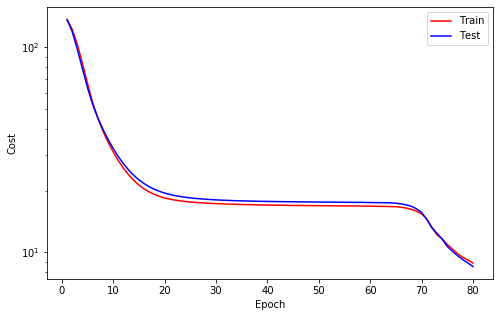



Epoch    81
Train_cost  = 8.6356 | Test_cost  = 8.2625 | 




Epoch    82
Train_cost  = 8.4516 | Test_cost  = 8.0057 | 




Epoch    83
Train_cost  = 8.2761 | Test_cost  = 7.7806 | 




Epoch    84
Train_cost  = 8.1098 | Test_cost  = 7.5972 | 




Epoch    85
Train_cost  = 7.9709 | Test_cost  = 7.4373 | 




Epoch    86
Train_cost  = 7.8494 | Test_cost  = 7.2967 | 




Epoch    87
Train_cost  = 7.7381 | Test_cost  = 7.1692 | 




Epoch    88
Train_cost  = 7.6376 | Test_cost  = 7.0554 | 




Epoch    89
Train_cost  = 7.5498 | Test_cost  = 6.9518 | 




Epoch    90
Train_cost  = 7.4712 | Test_cost  = 6.8583 | 




Epoch    91
Train_cost  = 7.4004 | Test_cost  = 6.7736 | 




Epoch    92
Train_cost  = 7.3363 | Test_cost  = 6.6976 | 




Epoch    93
Train_cost  = 7.2785 | Test_cost  = 6.6284 | 




Epoch    94
Train_cost  = 7.2256 | Test_cost  = 6.5650 | 




Epoch    95
Train_cost  = 7.1771 | Test_cost  = 6.5066 | 




Epoch    96
Train_cost  = 7.1323 | Test_cost  = 6.4527 | 




Epoch    97
Train_cost  = 7.0910 | Test_cost  = 6.4027 | 




Epoch    98
Train_cost  = 7.0526 | Test_cost  = 6.3561 | 




Epoch    99
Train_cost  = 7.0168 | Test_cost  = 6.3124 | 




Epoch   100
Train_cost  = 6.9833 | Test_cost  = 6.2714 | 


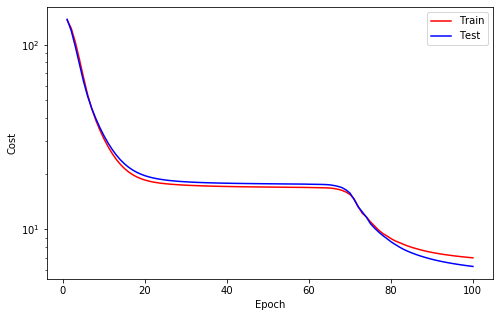



Epoch   101
Train_cost  = 6.9517 | Test_cost  = 6.2328 | 




Epoch   102
Train_cost  = 6.9219 | Test_cost  = 6.1961 | 




Epoch   103
Train_cost  = 6.8938 | Test_cost  = 6.1614 | 




Epoch   104
Train_cost  = 6.8670 | Test_cost  = 6.1284 | 




Epoch   105
Train_cost  = 6.8415 | Test_cost  = 6.0969 | 




Epoch   106
Train_cost  = 6.8171 | Test_cost  = 6.0668 | 




Epoch   107
Train_cost  = 6.7937 | Test_cost  = 6.0379 | 




Epoch   108
Train_cost  = 6.7712 | Test_cost  = 6.0102 | 




Epoch   109
Train_cost  = 6.7495 | Test_cost  = 5.9834 | 




Epoch   110
Train_cost  = 6.7286 | Test_cost  = 5.9576 | 




Epoch   111
Train_cost  = 6.7084 | Test_cost  = 5.9327 | 




Epoch   112
Train_cost  = 6.6890 | Test_cost  = 5.9088 | 




Epoch   113
Train_cost  = 6.6702 | Test_cost  = 5.8859 | 




Epoch   114
Train_cost  = 6.6521 | Test_cost  = 5.8640 | 




Epoch   115
Train_cost  = 6.6347 | Test_cost  = 5.8432 | 




Epoch   116
Train_cost  = 6.6180 | Test_cost  = 5.8234 | 




Epoch   117
Train_cost  = 6.6020 | Test_cost  = 5.8046 | 




Epoch   118
Train_cost  = 6.5866 | Test_cost  = 5.7869 | 




Epoch   119
Train_cost  = 6.5718 | Test_cost  = 5.7699 | 




Epoch   120
Train_cost  = 6.5575 | Test_cost  = 5.7536 | 


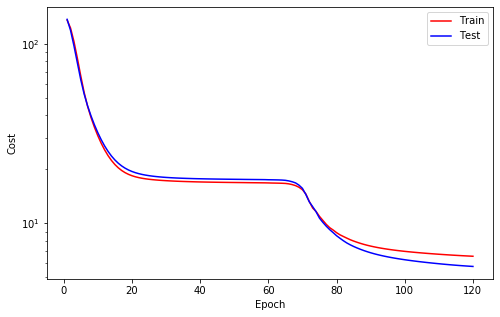



Epoch   121
Train_cost  = 6.5437 | Test_cost  = 5.7378 | 




Epoch   122
Train_cost  = 6.5302 | Test_cost  = 5.7222 | 




Epoch   123
Train_cost  = 6.5171 | Test_cost  = 5.7069 | 




Epoch   124
Train_cost  = 6.5043 | Test_cost  = 5.6917 | 




Epoch   125
Train_cost  = 6.4917 | Test_cost  = 5.6767 | 




Epoch   126
Train_cost  = 6.4795 | Test_cost  = 5.6620 | 




Epoch   127
Train_cost  = 6.4677 | Test_cost  = 5.6478 | 




Epoch   128
Train_cost  = 6.4562 | Test_cost  = 5.6340 | 




Epoch   129
Train_cost  = 6.4452 | Test_cost  = 5.6208 | 




Epoch   130
Train_cost  = 6.4344 | Test_cost  = 5.6080 | 




Epoch   131
Train_cost  = 6.4240 | Test_cost  = 5.5956 | 




Epoch   132
Train_cost  = 6.4139 | Test_cost  = 5.5837 | 




Epoch   133
Train_cost  = 6.4040 | Test_cost  = 5.5721 | 




Epoch   134
Train_cost  = 6.3943 | Test_cost  = 5.5609 | 




Epoch   135
Train_cost  = 6.3848 | Test_cost  = 5.5499 | 




Epoch   136
Train_cost  = 6.3755 | Test_cost  = 5.5392 | 




Epoch   137
Train_cost  = 6.3663 | Test_cost  = 5.5287 | 




Epoch   138
Train_cost  = 6.3572 | Test_cost  = 5.5183 | 




Epoch   139
Train_cost  = 6.3482 | Test_cost  = 5.5081 | 




Epoch   140
Train_cost  = 6.3394 | Test_cost  = 5.4980 | 


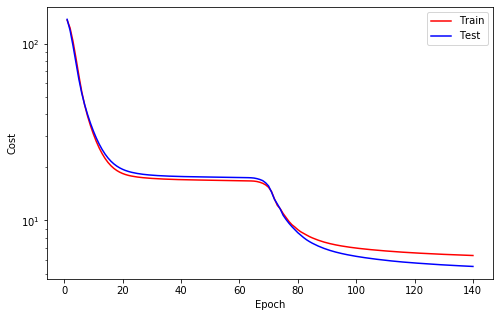



Epoch   141
Train_cost  = 6.3307 | Test_cost  = 5.4881 | 




Epoch   142
Train_cost  = 6.3221 | Test_cost  = 5.4784 | 




Epoch   143
Train_cost  = 6.3138 | Test_cost  = 5.4690 | 




Epoch   144
Train_cost  = 6.3055 | Test_cost  = 5.4597 | 




Epoch   145
Train_cost  = 6.2974 | Test_cost  = 5.4507 | 




Epoch   146
Train_cost  = 6.2895 | Test_cost  = 5.4419 | 




Epoch   147
Train_cost  = 6.2817 | Test_cost  = 5.4334 | 




Epoch   148
Train_cost  = 6.2740 | Test_cost  = 5.4251 | 




Epoch   149
Train_cost  = 6.2664 | Test_cost  = 5.4170 | 




Epoch   150
Train_cost  = 6.2588 | Test_cost  = 5.4090 | 




Epoch   151
Train_cost  = 6.2513 | Test_cost  = 5.4012 | 




Epoch   152
Train_cost  = 6.2439 | Test_cost  = 5.3935 | 




Epoch   153
Train_cost  = 6.2364 | Test_cost  = 5.3858 | 




Epoch   154
Train_cost  = 6.2290 | Test_cost  = 5.3782 | 




Epoch   155
Train_cost  = 6.2217 | Test_cost  = 5.3707 | 




Epoch   156
Train_cost  = 6.2144 | Test_cost  = 5.3633 | 




Epoch   157
Train_cost  = 6.2072 | Test_cost  = 5.3560 | 




Epoch   158
Train_cost  = 6.2001 | Test_cost  = 5.3488 | 




Epoch   159
Train_cost  = 6.1931 | Test_cost  = 5.3418 | 




Epoch   160
Train_cost  = 6.1861 | Test_cost  = 5.3350 | 


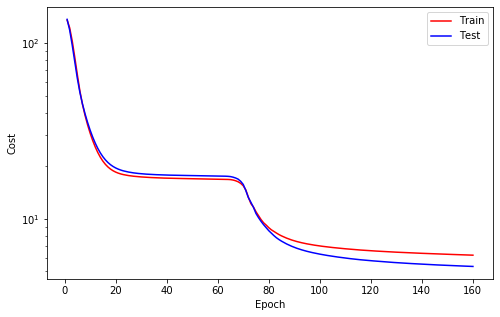



Epoch   161
Train_cost  = 6.1792 | Test_cost  = 5.3283 | 




Epoch   162
Train_cost  = 6.1724 | Test_cost  = 5.3217 | 




Epoch   163
Train_cost  = 6.1656 | Test_cost  = 5.3151 | 




Epoch   164
Train_cost  = 6.1588 | Test_cost  = 5.3088 | 




Epoch   165
Train_cost  = 6.1522 | Test_cost  = 5.3030 | 




Epoch   166
Train_cost  = 6.1458 | Test_cost  = 5.2975 | 




Epoch   167
Train_cost  = 6.1393 | Test_cost  = 5.2922 | 




Epoch   168
Train_cost  = 6.1328 | Test_cost  = 5.2870 | 




Epoch   169
Train_cost  = 6.1262 | Test_cost  = 5.2818 | 




Epoch   170
Train_cost  = 6.1195 | Test_cost  = 5.2766 | 




Epoch   171
Train_cost  = 6.1128 | Test_cost  = 5.2713 | 




Epoch   172
Train_cost  = 6.1062 | Test_cost  = 5.2660 | 




Epoch   173
Train_cost  = 6.0996 | Test_cost  = 5.2608 | 




Epoch   174
Train_cost  = 6.0932 | Test_cost  = 5.2558 | 




Epoch   175
Train_cost  = 6.0870 | Test_cost  = 5.2510 | 




Epoch   176
Train_cost  = 6.0810 | Test_cost  = 5.2464 | 




Epoch   177
Train_cost  = 6.0750 | Test_cost  = 5.2422 | 




Epoch   178
Train_cost  = 6.0691 | Test_cost  = 5.2383 | 




Epoch   179
Train_cost  = 6.0633 | Test_cost  = 5.2347 | 




Epoch   180
Train_cost  = 6.0574 | Test_cost  = 5.2313 | 


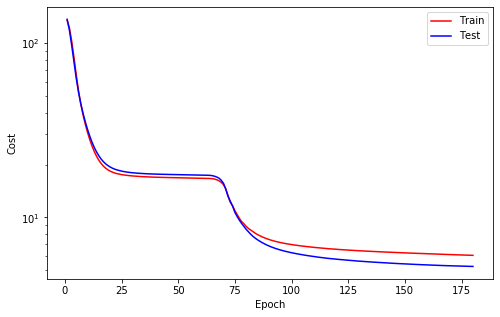



Epoch   181
Train_cost  = 6.0516 | Test_cost  = 5.2280 | 




Epoch   182
Train_cost  = 6.0456 | Test_cost  = 5.2249 | 




Epoch   183
Train_cost  = 6.0397 | Test_cost  = 5.2219 | 




Epoch   184
Train_cost  = 6.0337 | Test_cost  = 5.2189 | 




Epoch   185
Train_cost  = 6.0278 | Test_cost  = 5.2161 | 




Epoch   186
Train_cost  = 6.0220 | Test_cost  = 5.2134 | 




Epoch   187
Train_cost  = 6.0162 | Test_cost  = 5.2110 | 




Epoch   188
Train_cost  = 6.0105 | Test_cost  = 5.2088 | 




Epoch   189
Train_cost  = 6.0049 | Test_cost  = 5.2070 | 




Epoch   190
Train_cost  = 5.9994 | Test_cost  = 5.2055 | 




Epoch   191
Train_cost  = 5.9940 | Test_cost  = 5.2043 | 




Epoch   192
Train_cost  = 5.9885 | Test_cost  = 5.2034 | 




Epoch   193
Train_cost  = 5.9831 | Test_cost  = 5.2027 | 




Epoch   194
Train_cost  = 5.9775 | Test_cost  = 5.2019 | 




Epoch   195
Train_cost  = 5.9719 | Test_cost  = 5.2010 | 




Epoch   196
Train_cost  = 5.9661 | Test_cost  = 5.1997 | 




Epoch   197
Train_cost  = 5.9603 | Test_cost  = 5.1983 | 




Epoch   198
Train_cost  = 5.9544 | Test_cost  = 5.1968 | 




Epoch   199
Train_cost  = 5.9486 | Test_cost  = 5.1954 | 




Epoch   200
Train_cost  = 5.9428 | Test_cost  = 5.1944 | 


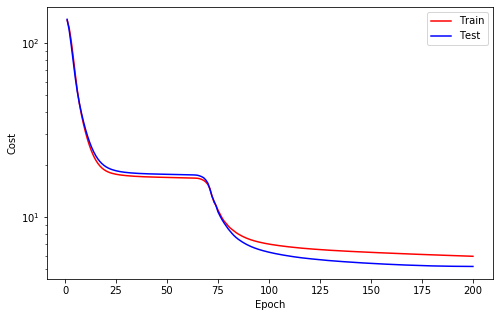



Epoch   201
Train_cost  = 5.9372 | Test_cost  = 5.1938 | 




Epoch   202
Train_cost  = 5.9317 | Test_cost  = 5.1937 | 




Epoch   203
Train_cost  = 5.9263 | Test_cost  = 5.1937 | 




Epoch   204
Train_cost  = 5.9209 | Test_cost  = 5.1930 | 




Epoch   205
Train_cost  = 5.9154 | Test_cost  = 5.1914 | 




Epoch   206
Train_cost  = 5.9097 | Test_cost  = 5.1886 | 




Epoch   207
Train_cost  = 5.9038 | Test_cost  = 5.1854 | 




Epoch   208
Train_cost  = 5.8979 | Test_cost  = 5.1828 | 




Epoch   209
Train_cost  = 5.8921 | Test_cost  = 5.1816 | 




Epoch   210
Train_cost  = 5.8864 | Test_cost  = 5.1825 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1816




Epoch   211
Train_cost  = 5.8809 | Test_cost  = 5.1851 | 
==> EarlyStop patience =  2 | Best test_cost: 5.1816




Epoch   212
Train_cost  = 5.8754 | Test_cost  = 5.1876 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1816




Epoch   213
Train_cost  = 5.8695 | Test_cost  = 5.1863 | 
==> EarlyStop patience =  4 | Best test_cost: 5.1816




Epoch   214
Train_cost  = 5.8625 | Test_cost  = 5.1790 | 




Epoch   215
Train_cost  = 5.8548 | Test_cost  = 5.1685 | 




Epoch   216
Train_cost  = 5.8477 | Test_cost  = 5.1590 | 




Epoch   217
Train_cost  = 5.8421 | Test_cost  = 5.1529 | 




Epoch   218
Train_cost  = 5.8378 | Test_cost  = 5.1512 | 




Epoch   219
Train_cost  = 5.8341 | Test_cost  = 5.1570 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1512




Epoch   220
Train_cost  = 5.8321 | Test_cost  = 5.1776 | 


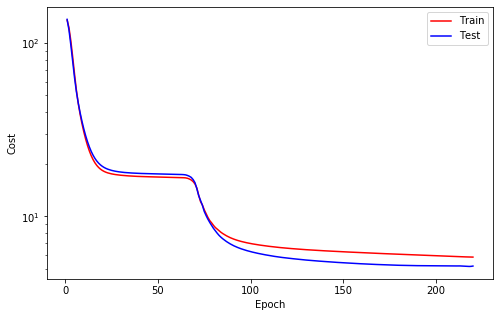

==> EarlyStop patience =  2 | Best test_cost: 5.1512




Epoch   221
Train_cost  = 5.8348 | Test_cost  = 5.2159 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1512




Epoch   222
Train_cost  = 5.8368 | Test_cost  = 5.2130 | 
==> EarlyStop patience =  4 | Best test_cost: 5.1512




Epoch   223
Train_cost  = 5.8201 | Test_cost  = 5.1503 | 




Epoch   224
Train_cost  = 5.7987 | Test_cost  = 5.1288 | 




Epoch   225
Train_cost  = 5.7955 | Test_cost  = 5.1270 | 




Epoch   226
Train_cost  = 5.7964 | Test_cost  = 5.1222 | 




Epoch   227
Train_cost  = 5.7906 | Test_cost  = 5.1662 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1222




Epoch   228
Train_cost  = 5.8079 | Test_cost  = 5.2300 | 
==> EarlyStop patience =  2 | Best test_cost: 5.1222




Epoch   229
Train_cost  = 5.8156 | Test_cost  = 5.1583 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1222




Epoch   230
Train_cost  = 5.7833 | Test_cost  = 5.1175 | 




Epoch   231
Train_cost  = 5.7680 | Test_cost  = 5.1182 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1175




Epoch   232
Train_cost  = 5.7626 | Test_cost  = 5.1648 | 
==> EarlyStop patience =  2 | Best test_cost: 5.1175




Epoch   233
Train_cost  = 5.7795 | Test_cost  = 5.2174 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1175




Epoch   234
Train_cost  = 5.7807 | Test_cost  = 5.1311 | 
==> EarlyStop patience =  4 | Best test_cost: 5.1175




Epoch   235
Train_cost  = 5.7388 | Test_cost  = 5.1102 | 




Epoch   236
Train_cost  = 5.7268 | Test_cost  = 5.1261 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1102




Epoch   237
Train_cost  = 5.7246 | Test_cost  = 5.1739 | 
==> EarlyStop patience =  2 | Best test_cost: 5.1102




Epoch   238
Train_cost  = 5.7369 | Test_cost  = 5.1586 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1102




Epoch   239
Train_cost  = 5.7115 | Test_cost  = 5.1214 | 
==> EarlyStop patience =  4 | Best test_cost: 5.1102




Epoch   240
Train_cost  = 5.6922 | Test_cost  = 5.1230 | 


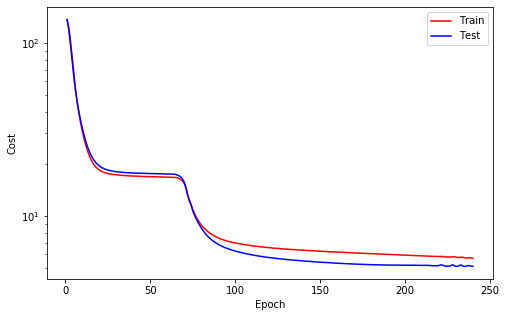

==> EarlyStop patience =  5 | Best test_cost: 5.1102
==> Execute Early Stopping at epoch: 240 | Best test_cost: 5.1102
==> Best model is saved at model/lstm


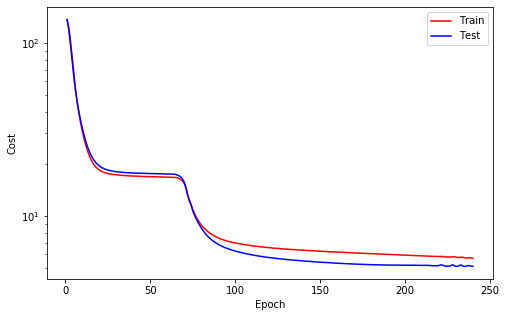

In [16]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging
    callback.log(train_cost, test_cost)
    
    # checkpoint
    callback.save_checkpoint()
    
    # Runtime plotting
    callback.cost_runtime_plotting()
    
    # Early stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break
        

# Sanity Check

In [19]:
from utils import data4pred, pred4pred

In [20]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



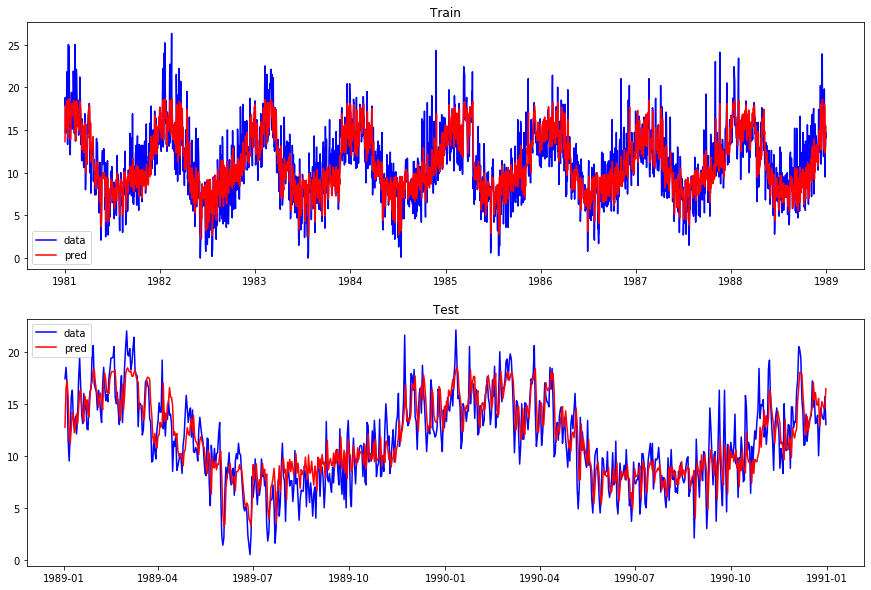

In [21]:
# data for prediksi
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test");

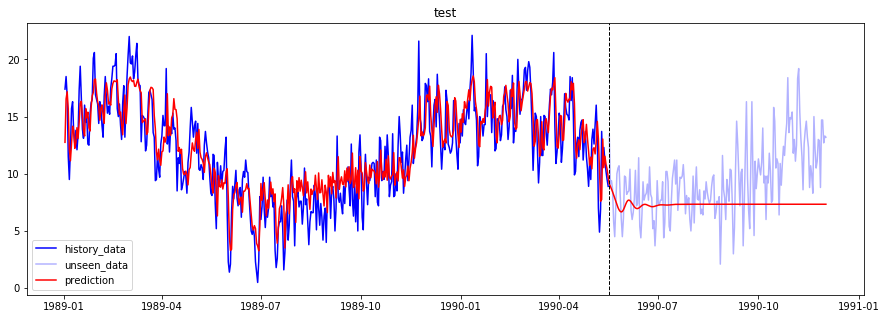

In [22]:
# prediksi 4 prediksi
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test");